# Sign Language Image Classification with Vision Transformers

### Kenyan Sign Languange Dataset


### Import packages

In [14]:
# Import necessary libraries
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from datasets import load_dataset
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from timm import create_model
from tqdm import tqdm
import numpy as np


### CustomDataset Class


In [15]:
class CustomDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset  # Directly store the dataset (no need for split)
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        # Access the subset's data directly
        data = self.dataset[idx]
        image = data['image']
        label = data['label']

        if self.transform:
            image = self.transform(image)

        return image, label


### Download and unzip dataset


In [ ]:

import os

# Set up dataset path and name
kaggle_dataset = "aykhannazimzada/azsl-dataset"
dataset_dir = "./sign-language-dataset"  # Path to store the dataset

# Ensure the dataset directory exists
if not os.path.exists(dataset_dir):
    os.makedirs(dataset_dir)
    print("Downloading dataset from Kaggle...")

    # Download and unzip the dataset
    os.system(f"kaggle datasets download -d {kaggle_dataset} -p {dataset_dir} --unzip")
    print("Dataset downloaded and unzipped.")
else:
    print("Dataset already downloaded.")



## Load dataset


In [4]:
from datasets import load_dataset

# Specify the correct paths for the train and test datasets
train_dataset_path = r"D:\Master\DNN\sign-language-image-detection\src\ViT\sign-datasets\sign_datasets\kenyan-dataset\train"
test_dataset_path = r"D:\Master\DNN\sign-language-image-detection\src\ViT\sign-datasets\sign_datasets\kenyan-dataset\test"

# Load the train and test datasets separately using `imagefolder` format
train_dataset = load_dataset('imagefolder', data_dir=train_dataset_path)
test_dataset = load_dataset('imagefolder', data_dir=test_dataset_path)

# Print dataset details to verify
print("Train Dataset:", train_dataset)
print("Test Dataset:", test_dataset)


Train Dataset: DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 4999
    })
})
Test Dataset: DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 1250
    })
})


## Get dataset pickle

In [16]:
import os
import pickle
from datasets import load_dataset

# Specify dataset paths
train_dataset_path = r"D:\Master\DNN\sign-language-image-detection\src\ViT\sign-datasets\sign_datasets\kenyan-dataset\train"
test_dataset_path = r"D:\Master\DNN\sign-language-image-detection\src\ViT\sign-datasets\sign_datasets\kenyan-dataset\test"

# Cache filenames for train and test datasets
train_cache_file = "kenyan_train_dataset_cache.pkl"
test_cache_file = "kenyan_test_dataset_cache.pkl"

# Load train dataset from cache or source
if os.path.exists(train_cache_file):
    print("Loading train dataset from cache...")
    with open(train_cache_file, "rb") as f:
        train_dataset = pickle.load(f)
else:
    print("Loading train dataset from source and caching it...")
    train_dataset = load_dataset('imagefolder', data_dir=train_dataset_path)
    with open(train_cache_file, "wb") as f:
        pickle.dump(train_dataset, f)

# Load test dataset from cache or source
if os.path.exists(test_cache_file):
    print("Loading test dataset from cache...")
    with open(test_cache_file, "rb") as f:
        test_dataset = pickle.load(f)
else:
    print("Loading test dataset from source and caching it...")
    test_dataset = load_dataset('imagefolder', data_dir=test_dataset_path)
    with open(test_cache_file, "wb") as f:
        pickle.dump(test_dataset, f)

# Print dataset details to verify
print("Train Dataset:", train_dataset)
print("Test Dataset:", test_dataset)


Loading train dataset from cache...
Loading test dataset from cache...
Train Dataset: DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 4999
    })
})
Test Dataset: DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 1250
    })
})


## Print images dimensions


In [5]:
from PIL import Image

import os
from PIL import Image

# Corrected file path based on your message
file_path = r"D:\Master\DNN\sign-language-image-detection\src\ViT\sign-datasets\sign_datasets\kenyan-dataset\train\Church\ImageID_0C7FSZ03.jpg"

# Check if the file exists
if os.path.exists(file_path):
    # Open the image if it exists
    img = Image.open(file_path)
    print(f"Image dimensions: {img.size}")
else:
    print(f"File not found: {file_path}")




Image dimensions: (512, 512)


### Method to calculate dataset mean and std
- Convert images to tensors to calculate mean and std
### Dataset mean, std and number of classes

In [5]:
def calculate_mean_std(dataset):
    loader = DataLoader(dataset, batch_size=64, shuffle=False)
    mean = 0.0
    std = 0.0
    total_pixels = 0  # Total number of pixels across all images

    for images, _ in loader:
        # Number of pixels in the batch (batch_size x height x width)
        batch_pixels = images.size(0) * images.size(2) * images.size(3)
        total_pixels += batch_pixels

        # Sum of means for the batch (across channels)
        mean += images.sum(dim=[0, 2, 3])  # Sum over height and width
        # Sum of squared differences for the batch
        std += (images ** 2).sum(dim=[0, 2, 3])

    # Divide by the total number of pixels to get the mean
    mean /= total_pixels
    # Divide by the total number of pixels, then sqrt to get the std
    std = torch.sqrt(std / total_pixels - mean ** 2)
    return mean, std


In [6]:
transform_resized = transforms.Compose([
    transforms.Resize((224, 224)),    # Resize the image to 224x224
    transforms.ToTensor(),            # Convert image to tensor
])

In [8]:
# Ensure you're passing the correct split of the dataset to CustomDataset
train_split = train_dataset['train']  # Access the 'train' split of your dataset

# Create the transformed dataset
train_dataset_transformed = CustomDataset(train_split, transform=transform_resized)

# Calculate mean and std using the transformed dataset
mean, std = calculate_mean_std(train_dataset_transformed)

# Print the calculated mean and std
print(f"Mean: {mean}")
print(f"Std: {std}")


Mean: tensor([0.4576, 0.4086, 0.3969])
Std: tensor([0.2515, 0.2378, 0.2359])


In [6]:
def calculate_num_classes(dataset):
    labels = [example['label'] for example in dataset]
    num_classes = len(set(labels))  # Get unique labels
    return num_classes

In [7]:
num_classes = calculate_num_classes(train_dataset['train'])


In [12]:
print(f"Number of classes in the dataset: {num_classes}")

Number of classes in the dataset: 9


In [18]:
# mean, std = calculate_mean_std(dataset['train'])
mean = [0.4576, 0.4086, 0.3969]
std = [0.2515, 0.2378, 0.2359]
num_classes = 9

In [8]:
print(f"Number of classes: {num_classes}")
print(f" calculated mean: {mean}")
print(f" calculated std: {std}")

Number of classes: 9
 calculated mean: [0.4576, 0.4086, 0.3969]
 calculated std: [0.2515, 0.2378, 0.2359]


## Data Preprocessing: Normalization, Splitting, and DataLoader Creation


In [20]:
from torch.utils.data import random_split
from torchvision import transforms
from torchvision.datasets import ImageFolder 
# Now, apply the normalization step after calculating mean and std
transform_norm = transforms.Compose([
    transforms.Resize((224, 224)),    # Resize the image to 224x224
    transforms.ToTensor(),            # Convert image to tensor
    transforms.Normalize(mean=mean, std=std)  # Normalize the image with calculated mean and std
])
# Apply transformation to datasets
train_dataset = ImageFolder(root=train_dataset_path, transform=transform_norm)
test_dataset = ImageFolder(root=test_dataset_path, transform=transform_norm)

# Now, split the training dataset into train and validation
total_size = len(train_dataset)
train_size = int(0.8 * total_size)  # 80% for training
val_size = total_size - train_size  # Remaining 20% for validation

train_split, val_split = random_split(train_dataset, [train_size, val_size])

# Create DataLoaders for train, validation, and test datasets
batch_size = 64
train_loader_resized = DataLoader(train_split, batch_size=batch_size, shuffle=True)
val_loader_resized = DataLoader(val_split, batch_size=batch_size, shuffle=False)
test_loader_resized = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


### Print tensors shapes as a sanity check


In [17]:
for images, labels in train_loader_resized:
    print(images.shape)  # Should print [64, 3, 224, 224]
    break  # Just to check one batch

torch.Size([64, 3, 224, 224])


## Plot class distributions


In [26]:
import matplotlib.pyplot as plt
from collections import Counter

# Function to plot class distribution with enhanced visualization
def plot_class_distribution(dataset, title):
    # Count occurrences of each class
    class_counts = Counter([dataset[i][1] for i in range(len(dataset))])
    
    # Sort class labels and counts
    labels, counts = zip(*sorted(class_counts.items()))
    
    # Create a larger figure for better visibility
    plt.figure(figsize=(12, 6))  # Set figure size (adjust as needed)
    
    # Plot the distribution
    plt.bar(labels, counts, tick_label=[str(label) for label in labels], color='skyblue')
    plt.xlabel('Class Labels', fontsize=14)
    plt.ylabel('Number of Samples', fontsize=14)
    plt.title(title, fontsize=16)
    
    # Rotate tick labels for better readability if there are many classes
    plt.xticks( fontsize=12)
    
    # Increase the size of the y-axis labels and ticks for better visibility
    plt.yticks(fontsize=12)
    
    # Display the plot
    plt.tight_layout()  # Adjust layout to fit everything
    plt.show()




### Train split


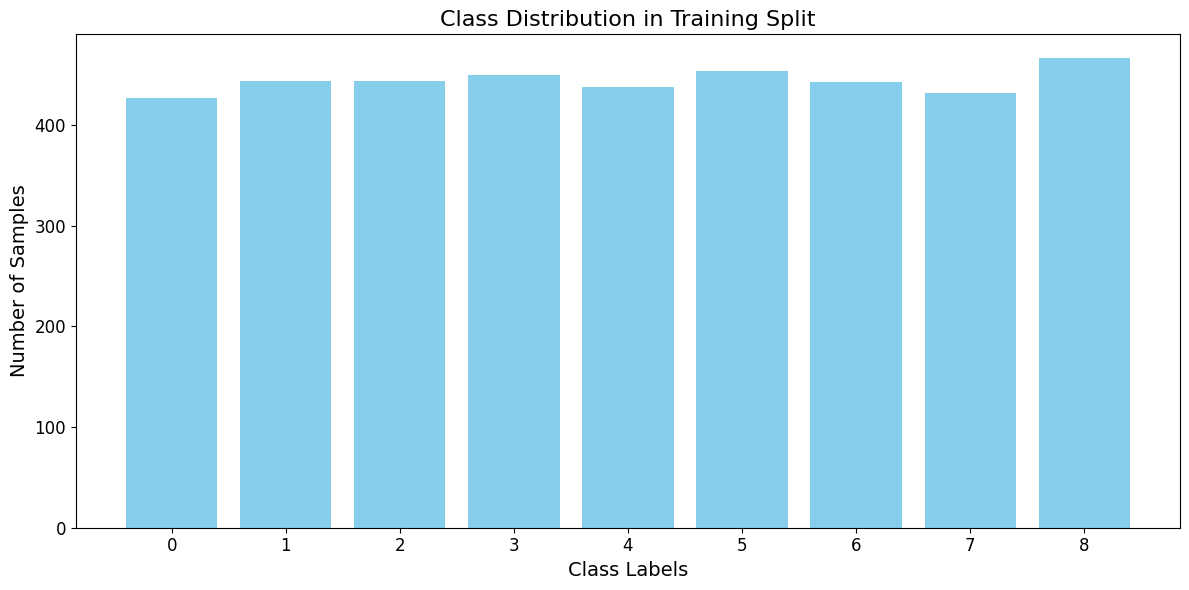

In [27]:
plot_class_distribution(train_split, "Class Distribution in Training Split")

### Validation split


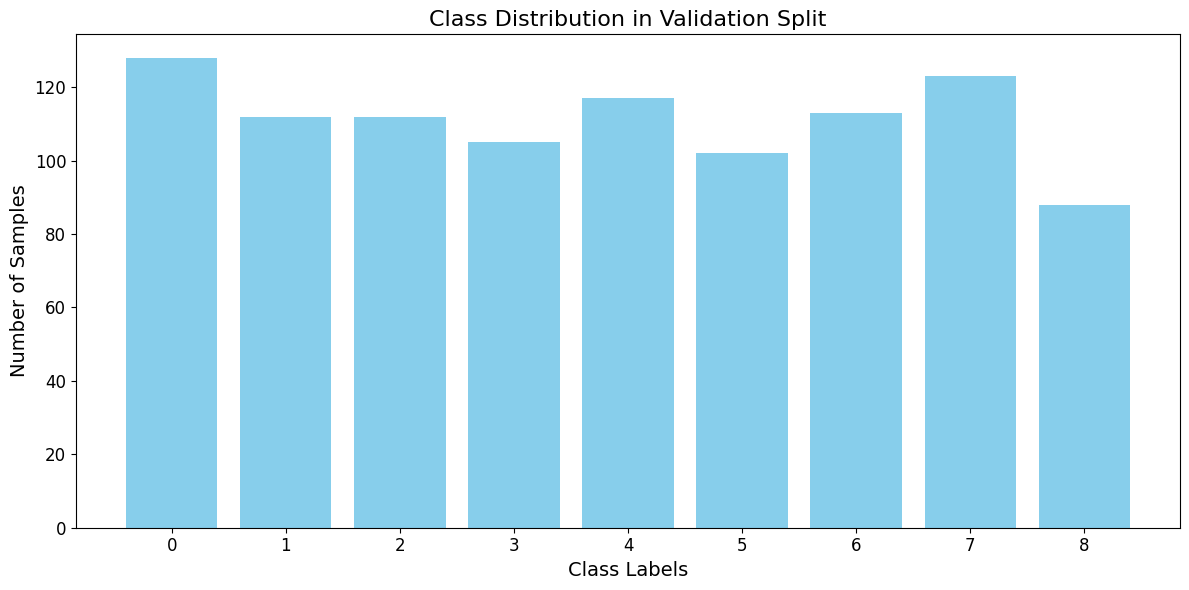

In [20]:
# Plot for validation split
plot_class_distribution(val_split, "Class Distribution in Validation Split")

### Test split


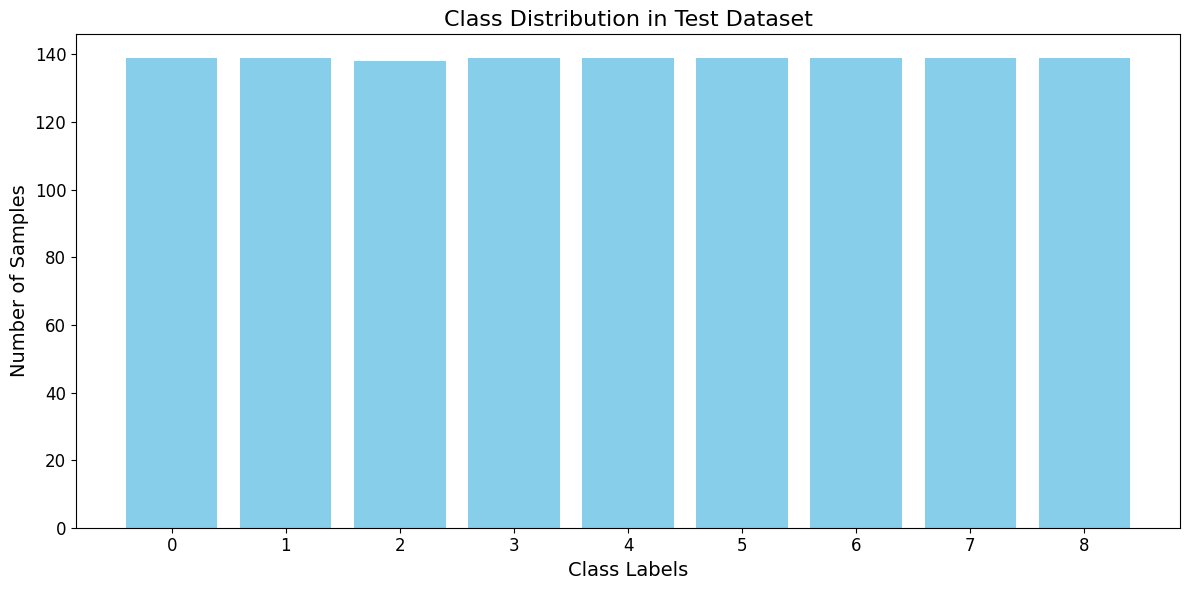

In [21]:
# Plot for test dataset
plot_class_distribution(test_dataset, "Class Distribution in Test Dataset")

### Model Training - Full Vit Training

#### Trainer Class

In [21]:
from tqdm import tqdm
import torch

class Trainer:
    def __init__(self, model, optimizer, loss_fn, device, scheduler=None):
        """
        Initialize the Trainer class.

        Args:
            model (torch.nn.Module): The model to train.
            optimizer (torch.optim.Optimizer): Optimizer for updating weights.
            loss_fn (torch.nn.Module): Loss function.
            device (torch.device): Device to run training (CPU/GPU).
            scheduler (torch.optim.lr_scheduler, optional): Learning rate scheduler. Default is None.
        """
        self.model = model.to(device)
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.device = device
        self.scheduler = scheduler  # Optional scheduler

    def train_epoch(self, train_loader):
        """Train for one epoch and return loss and accuracy."""
        self.model.train()
        total_loss = 0
        correct = 0

        with tqdm(train_loader, desc="Training", unit="batch") as t:
            for images, labels in t:
                images, labels = images.to(self.device), labels.to(self.device)
                self.optimizer.zero_grad()
                logits = self.model(images)
                loss = self.loss_fn(logits, labels)
                loss.backward()
                self.optimizer.step()

                # Track loss and correct predictions
                total_loss += loss.item() * len(images)
                predictions = torch.argmax(logits, dim=1)
                correct += (predictions == labels).sum().item()

                t.set_postfix(loss=loss.item())
        
        # Compute average loss and accuracy
        avg_loss = total_loss / len(train_loader.dataset)
        accuracy = correct / len(train_loader.dataset)
        return avg_loss, accuracy

    @torch.no_grad()
    def evaluate(self, dataloader):
        """Evaluate the model and return loss and accuracy."""
        self.model.eval()
        total_loss = 0
        correct = 0

        with tqdm(dataloader, desc="Validating", unit="batch") as t:
            for images, labels in t:
                images, labels = images.to(self.device), labels.to(self.device)
                logits = self.model(images)
                loss = self.loss_fn(logits, labels)

                # Track loss and correct predictions
                total_loss += loss.item() * len(images)
                predictions = torch.argmax(logits, dim=1)
                correct += (predictions == labels).sum().item()

        # Compute average loss and accuracy
        avg_loss = total_loss / len(dataloader.dataset)
        accuracy = correct / len(dataloader.dataset)
        return avg_loss, accuracy

    def get_current_lr(self):
        """Retrieve the current learning rate from the optimizer."""
        return self.optimizer.param_groups[0]['lr']

    def train(self, train_loader, val_loader, epochs):
        """Train the model and evaluate it after each epoch."""
        train_losses, train_accuracies = [], []
        val_losses, val_accuracies = [], []
        learning_rates = []  # Track learning rate for each epoch

        for epoch in range(epochs):
            print(f"Epoch {epoch + 1}/{epochs}")
            
            # Training phase
            train_loss, train_accuracy = self.train_epoch(train_loader)
            train_losses.append(train_loss)
            train_accuracies.append(train_accuracy)
            
            # Validation phase
            val_loss, val_accuracy = self.evaluate(val_loader)
            val_losses.append(val_loss)
            val_accuracies.append(val_accuracy)
            
            # Get the learning rate
            current_lr = self.get_current_lr()
            learning_rates.append(current_lr)
            
            # Print epoch metrics
            print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
            print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")
            print(f"Learning Rate: {current_lr:.6f}")
            
            # Step the scheduler, if provided
            if self.scheduler:
                self.scheduler.step(val_loss)  # Use validation loss for ReduceLROnPlateau
            
            torch.cuda.empty_cache()

        return train_losses, train_accuracies, val_losses, val_accuracies, learning_rates




## Confusion Matrix Plot


In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, class_names, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.show()


## ViT Tiny Whole model Fine-tuning


In [12]:
from torch.optim.lr_scheduler import CosineAnnealingLR
import torch.nn as nn
from timm import create_model
import time
# Load the pre-trained ViT-Tiny model from timm
model = create_model(
    "vit_tiny_patch16_224",  # Pre-trained ViT-Tiny on ImageNet-1k
    pretrained=True,         # Load pre-trained weights
    num_classes=num_classes  # Use dynamic number of classes
)



# Unfreeze the entire model (train all layers)
for param in model.parameters():
    param.requires_grad = True

# Define optimizer with adjusted learning rate and weight decay
optimizer = optim.AdamW(
    model.parameters(), lr=1e-5, weight_decay=5e-2
)

# Define CrossEntropy loss function
loss_fn = nn.CrossEntropyLoss()


# Define device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move model to device
model = model.to(device)

# Train the full ViT model
trainer = Trainer(model, optimizer, loss_fn, device, scheduler=None)

start_time = time.time()

train_losses, train_accuracies, val_losses, val_accuracies, learning_rates = trainer.train(
    train_loader_resized, val_loader_resized, epochs=10
)

# End timer after training
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Print learning rates for each epoch
print("Learning rates per epoch:", learning_rates)
print(f"Training completed in: {elapsed_time:.2f} seconds")

Epoch 1/10


Validating: 100%|██████████| 16/16 [00:08<00:00,  1.96batch/s]


Train Loss: 2.2499, Train Accuracy: 0.1815
Validation Loss: 1.9836, Validation Accuracy: 0.2900
Learning Rate: 0.000010
Epoch 2/10


Validating: 100%|██████████| 16/16 [00:11<00:00,  1.40batch/s]


Train Loss: 1.5944, Train Accuracy: 0.4606
Validation Loss: 1.3666, Validation Accuracy: 0.5290
Learning Rate: 0.000010
Epoch 3/10


Validating: 100%|██████████| 16/16 [00:08<00:00,  1.86batch/s]


Train Loss: 0.9636, Train Accuracy: 0.7084
Validation Loss: 0.8590, Validation Accuracy: 0.7280
Learning Rate: 0.000010
Epoch 4/10


Validating: 100%|██████████| 16/16 [00:09<00:00,  1.75batch/s]


Train Loss: 0.5893, Train Accuracy: 0.8367
Validation Loss: 0.6492, Validation Accuracy: 0.8000
Learning Rate: 0.000010
Epoch 5/10


Validating: 100%|██████████| 16/16 [00:11<00:00,  1.42batch/s]


Train Loss: 0.4014, Train Accuracy: 0.8962
Validation Loss: 0.5533, Validation Accuracy: 0.8300
Learning Rate: 0.000010
Epoch 6/10


Validating: 100%|██████████| 16/16 [00:08<00:00,  1.89batch/s]


Train Loss: 0.2878, Train Accuracy: 0.9315
Validation Loss: 0.5077, Validation Accuracy: 0.8440
Learning Rate: 0.000010
Epoch 7/10


Validating: 100%|██████████| 16/16 [00:13<00:00,  1.19batch/s]


Train Loss: 0.2106, Train Accuracy: 0.9537
Validation Loss: 0.4809, Validation Accuracy: 0.8560
Learning Rate: 0.000010
Epoch 8/10


Validating: 100%|██████████| 16/16 [00:11<00:00,  1.35batch/s]


Train Loss: 0.1539, Train Accuracy: 0.9717
Validation Loss: 0.4695, Validation Accuracy: 0.8630
Learning Rate: 0.000010
Epoch 9/10


Validating: 100%|██████████| 16/16 [00:14<00:00,  1.08batch/s]


Train Loss: 0.1110, Train Accuracy: 0.9817
Validation Loss: 0.4649, Validation Accuracy: 0.8660
Learning Rate: 0.000010
Epoch 10/10


Validating: 100%|██████████| 16/16 [00:10<00:00,  1.58batch/s]

Train Loss: 0.0805, Train Accuracy: 0.9907
Validation Loss: 0.4643, Validation Accuracy: 0.8680
Learning Rate: 0.000010
Learning rates per epoch: [1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05]
Training completed in: 621.29 seconds


### Validation - Training loss and accuracy plot


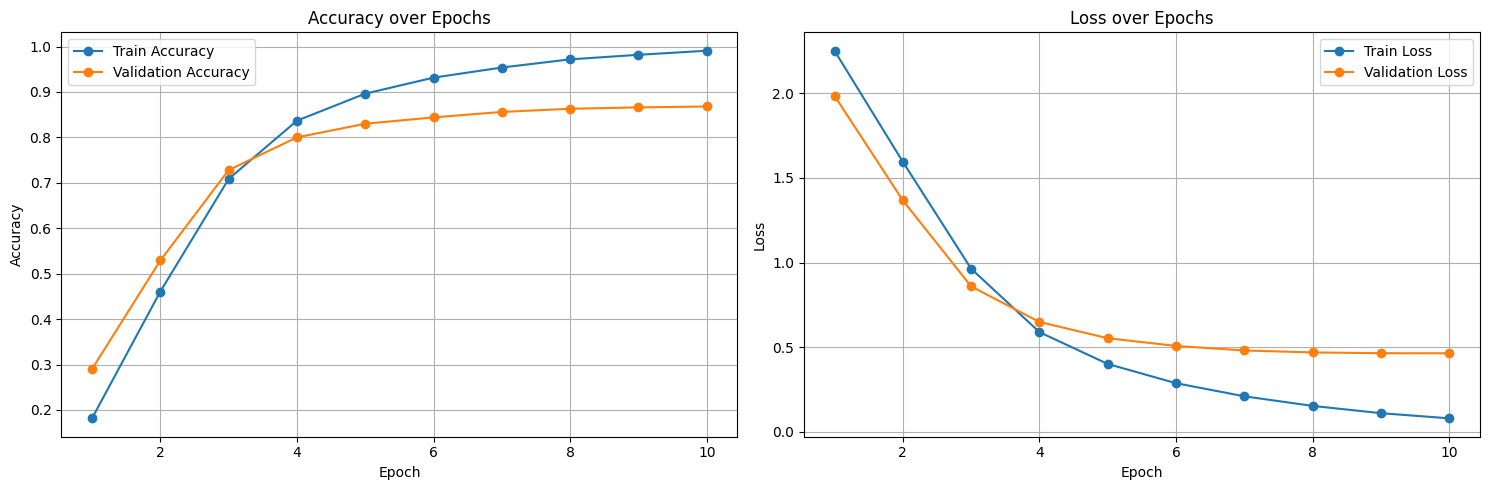

In [13]:
import matplotlib.pyplot as plt

# Create subplots: one for accuracy and one for loss
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot train and validation accuracy
axes[0].plot(range(1, len(train_accuracies) + 1), train_accuracies, marker='o', label="Train Accuracy")
axes[0].plot(range(1, len(val_accuracies) + 1), val_accuracies, marker='o', label="Validation Accuracy")
axes[0].set_title("Accuracy over Epochs")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Accuracy")
axes[0].grid(True)
axes[0].legend()

# Plot train and validation loss
axes[1].plot(range(1, len(train_losses) + 1), train_losses, marker='o', label="Train Loss")
axes[1].plot(range(1, len(val_losses) + 1), val_losses, marker='o', label="Validation Loss")
axes[1].set_title("Loss over Epochs")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Loss")
axes[1].grid(True)
axes[1].legend()

# Adjust layout and display the plots
plt.tight_layout()
plt.show()


### ViT-Tiny Confusion Matrix Plot


In [14]:
import torch
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate predictions and true labels
y_true_classifier = []
y_pred_classifier = []
class_names = train_dataset.classes  # Automatically get class names from dataset

model.eval()  # Set model to evaluation mode
with torch.no_grad():
    for images, labels in val_loader_resized:  # Use the validation DataLoader
        images, labels = images.to(device), labels.to(device)
        logits = model(images)
        predictions = torch.argmax(logits, dim=1)
        y_true_classifier.extend(labels.cpu().numpy())
        y_pred_classifier.extend(predictions.cpu().numpy())

# Calculate confusion matrix
cm = confusion_matrix(y_true_classifier, y_pred_classifier)





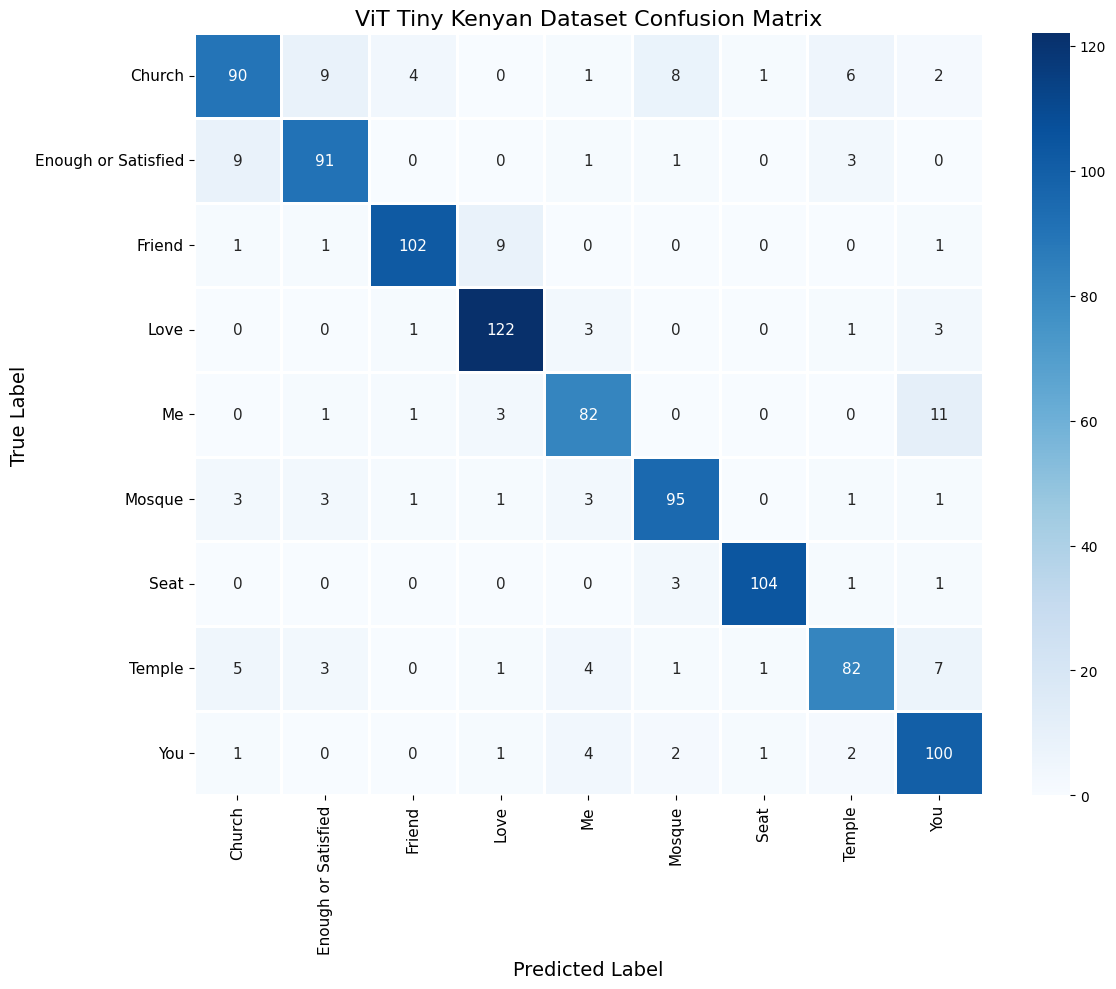

In [15]:
# Plot the confusion matrix with a larger figure size and bigger margins
plt.figure(figsize=(12, 10))  # Adjust the figsize to make the plot larger
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, cbar=True,
            annot_kws={"size": 11}, linewidths=1.8)  # Increase linewidth for better visibility of borders
plt.title("ViT Tiny Kenyan Dataset Confusion Matrix", fontsize=16)  # Increase font size of the title
plt.xlabel("Predicted Label", fontsize=14)  # Increase font size of the x-axis label
plt.ylabel("True Label", fontsize=14)  # Increase font size of the y-axis label
plt.xticks(fontsize=11)  # Set x-tick font size
plt.yticks(fontsize=11)

# Adjust the padding around the plot and labels
plt.subplots_adjust(left=0.2, right=0.8, top=0.85, bottom=0.15)  # Adjust the plot margins
plt.tight_layout()  # Ensure everything fits nicely within the plot area
plt.show()


### Calculate test accuracy


In [16]:
test_loss, test_accuracy = trainer.evaluate(test_loader_resized)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

Validating: 100%|██████████| 20/20 [00:27<00:00,  1.37s/batch]

Test Loss: 0.4550, Test Accuracy: 0.8608


## ViT-Tiny Classifier Only Fine-Tuning


In [30]:
import time
from torch.optim.lr_scheduler import CosineAnnealingLR
import torch.nn as nn
from timm import create_model
import torch.optim as optim

# Load the pre-trained ViT-Tiny model from timm
model = create_model(
    "vit_tiny_patch16_224",  # Pre-trained ViT-Tiny on ImageNet-1k
    pretrained=True,         # Load pre-trained weights
    num_classes=num_classes  # Use dynamic number of classes
)

# Freeze all layers except the classifier head
for param in model.parameters():
    param.requires_grad = False


# Only unfreeze the classifier head
for param in model.head.parameters():
    param.requires_grad = True


# Define optimizer with adjusted learning rate and weight decay
optimizer = optim.AdamW(
    model.parameters(), lr=2e-3, weight_decay=1e-4
)
# Define CrossEntropy loss function
loss_fn = nn.CrossEntropyLoss()

# Define Cosine Annealing scheduler
# Define ReduceLROnPlateau scheduler
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=1, factor=0.2)
# Define StepLR scheduler
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)

# Define device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move model to device
model = model.to(device)

# Train only the classifier head
trainer = Trainer(model, optimizer, loss_fn, device)
# Start timer before training
start_time = time.time()

train_losses, train_accuracies, val_losses, val_accuracies, learning_rates = trainer.train(
    train_loader_resized, val_loader_resized, epochs=10
)

# End timer after training
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Print learning rates for each epoch
print("Learning rates per epoch:", learning_rates)
print(f"Training completed in: {elapsed_time:.2f} seconds")


Epoch 1/10


Validating: 100%|██████████| 16/16 [00:07<00:00,  2.11batch/s]


Train Loss: 1.8190, Train Accuracy: 0.3416
Validation Loss: 1.6196, Validation Accuracy: 0.4390
Learning Rate: 0.002000
Epoch 2/10


Validating: 100%|██████████| 16/16 [00:08<00:00,  1.96batch/s]


Train Loss: 1.4144, Train Accuracy: 0.5024
Validation Loss: 1.5067, Validation Accuracy: 0.4700
Learning Rate: 0.002000
Epoch 3/10


Validating: 100%|██████████| 16/16 [00:08<00:00,  1.89batch/s]


Train Loss: 1.3198, Train Accuracy: 0.5316
Validation Loss: 1.4730, Validation Accuracy: 0.4930
Learning Rate: 0.002000
Epoch 4/10


Validating: 100%|██████████| 16/16 [00:12<00:00,  1.30batch/s]


Train Loss: 1.2787, Train Accuracy: 0.5509
Validation Loss: 1.4589, Validation Accuracy: 0.5090
Learning Rate: 0.002000
Epoch 5/10


Validating: 100%|██████████| 16/16 [00:12<00:00,  1.32batch/s]


Train Loss: 1.2456, Train Accuracy: 0.5629
Validation Loss: 1.4856, Validation Accuracy: 0.4890
Learning Rate: 0.002000
Epoch 6/10


Validating: 100%|██████████| 16/16 [00:17<00:00,  1.10s/batch]


Train Loss: 1.2292, Train Accuracy: 0.5669
Validation Loss: 1.4984, Validation Accuracy: 0.4900
Learning Rate: 0.002000
Epoch 7/10


Validating: 100%|██████████| 16/16 [00:07<00:00,  2.06batch/s]


Train Loss: 1.2091, Train Accuracy: 0.5691
Validation Loss: 1.4938, Validation Accuracy: 0.4940
Learning Rate: 0.002000
Epoch 8/10


Validating: 100%|██████████| 16/16 [00:07<00:00,  2.20batch/s]


Train Loss: 1.2033, Train Accuracy: 0.5771
Validation Loss: 1.5074, Validation Accuracy: 0.4960
Learning Rate: 0.002000
Epoch 9/10


Validating: 100%|██████████| 16/16 [00:08<00:00,  1.96batch/s]


Train Loss: 1.1925, Train Accuracy: 0.5756
Validation Loss: 1.5076, Validation Accuracy: 0.4930
Learning Rate: 0.002000
Epoch 10/10


Validating: 100%|██████████| 16/16 [00:08<00:00,  1.99batch/s]

Train Loss: 1.1888, Train Accuracy: 0.5799
Validation Loss: 1.5276, Validation Accuracy: 0.4820
Learning Rate: 0.002000
Learning rates per epoch: [0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002]
Training completed in: 490.64 seconds


### Validation - Training loss and accuracy plot


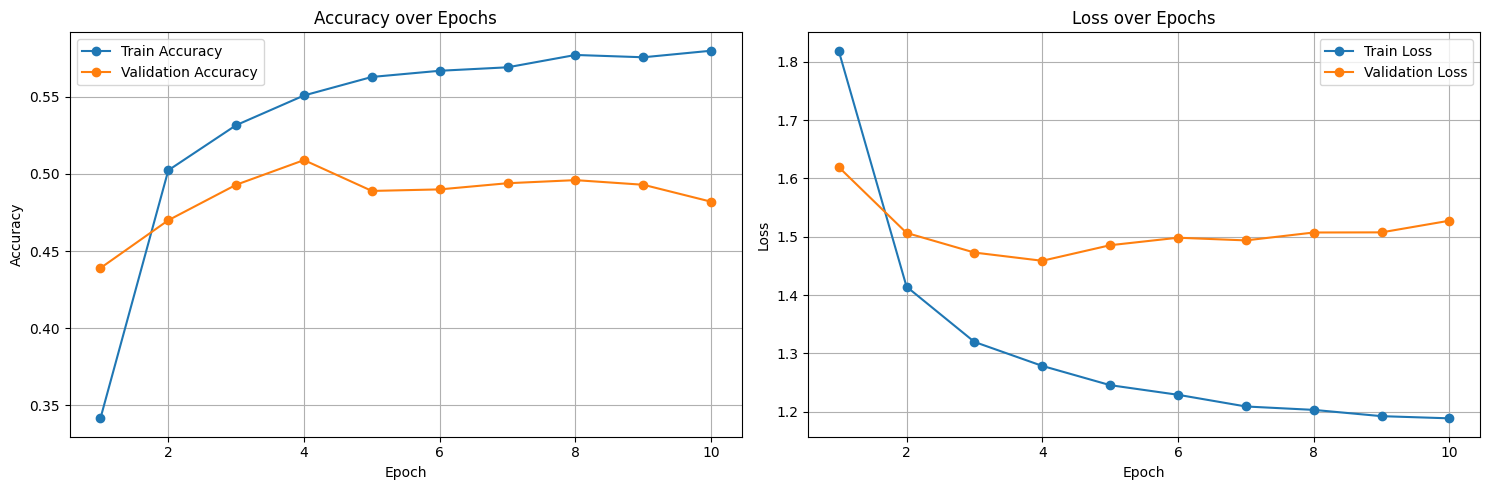

In [31]:
import matplotlib.pyplot as plt

# Create subplots: one for accuracy and one for loss
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot train and validation accuracy
axes[0].plot(range(1, len(train_accuracies) + 1), train_accuracies, marker='o', label="Train Accuracy")
axes[0].plot(range(1, len(val_accuracies) + 1), val_accuracies, marker='o', label="Validation Accuracy")
axes[0].set_title("Accuracy over Epochs")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Accuracy")
axes[0].grid(True)
axes[0].legend()

# Plot train and validation loss
axes[1].plot(range(1, len(train_losses) + 1), train_losses, marker='o', label="Train Loss")
axes[1].plot(range(1, len(val_losses) + 1), val_losses, marker='o', label="Validation Loss")
axes[1].set_title("Loss over Epochs")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Loss")
axes[1].grid(True)
axes[1].legend()

# Adjust layout and display the plots
plt.tight_layout()
plt.show()


### ViT-Tiny Classifier Only Confusion Matrix Plot


In [32]:
# Generate predictions and true labels
y_true_classifier = []
y_pred_classifier = []
class_names = train_dataset.classes  # Automatically get class names from dataset

model.eval()  # Set model to evaluation mode
with torch.no_grad():
    for images, labels in val_loader_resized:  # Use the validation DataLoader
        images, labels = images.to(device), labels.to(device)
        logits = model(images)
        predictions = torch.argmax(logits, dim=1)
        y_true_classifier.extend(labels.cpu().numpy())
        y_pred_classifier.extend(predictions.cpu().numpy())

# Calculate confusion matrix
cm = confusion_matrix(y_true_classifier, y_pred_classifier)


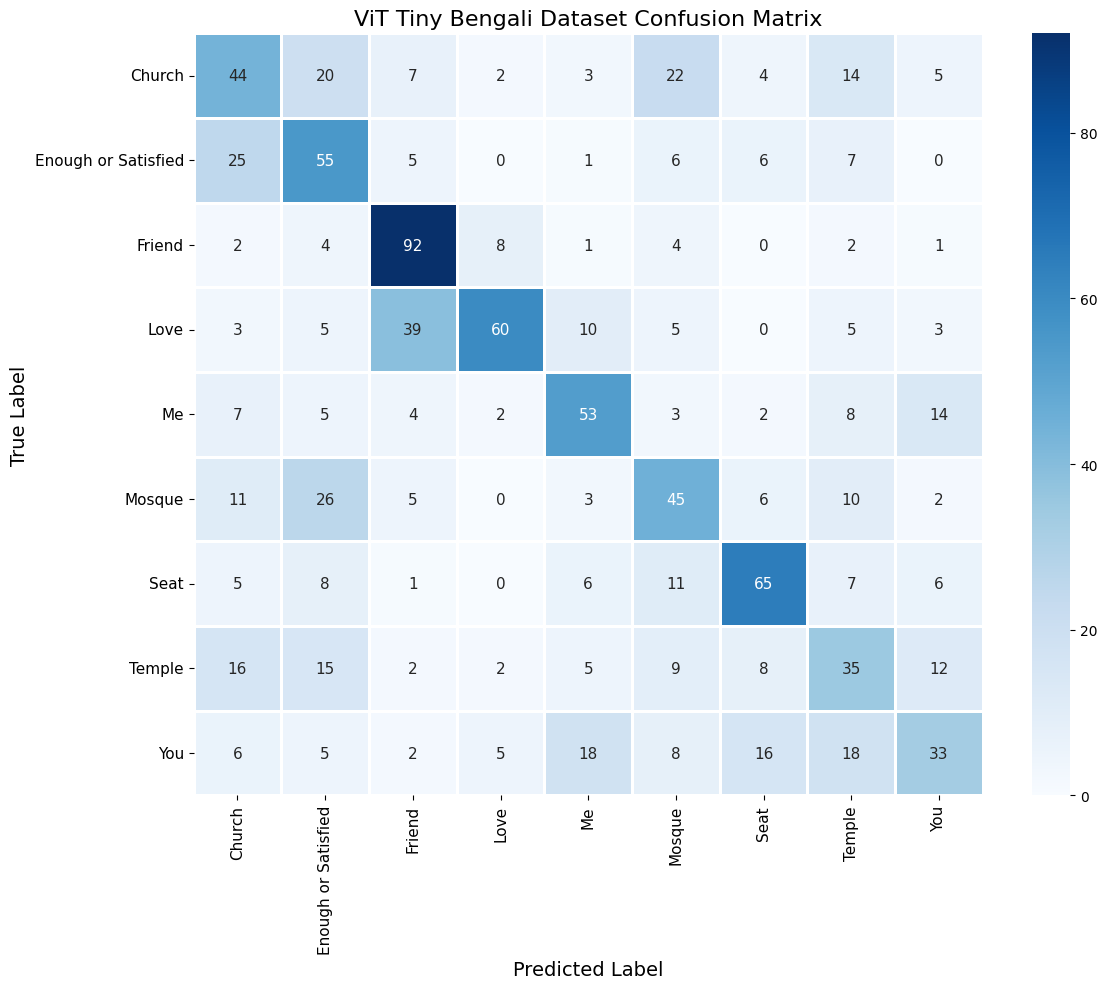

In [33]:
# Plot the confusion matrix with a larger figure size and bigger margins
plt.figure(figsize=(12, 10))  # Adjust the figsize to make the plot larger
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, cbar=True,
            annot_kws={"size": 11}, linewidths=1.8)  # Increase linewidth for better visibility of borders
plt.title("ViT Tiny Bengali Dataset Confusion Matrix", fontsize=16)  # Increase font size of the title
plt.xlabel("Predicted Label", fontsize=14)  # Increase font size of the x-axis label
plt.ylabel("True Label", fontsize=14)  # Increase font size of the y-axis label
plt.xticks(fontsize=11)  # Set x-tick font size
plt.yticks(fontsize=11)

# Adjust the padding around the plot and labels
plt.subplots_adjust(left=0.2, right=0.8, top=0.85, bottom=0.15)  # Adjust the plot margins
plt.tight_layout()  # Ensure everything fits nicely within the plot area
plt.show()

### Calculate test accuracy


In [34]:
test_loss, test_accuracy = trainer.evaluate(test_loader_resized)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

Validating: 100%|██████████| 20/20 [00:20<00:00,  1.03s/batch]

Test Loss: 1.5014, Test Accuracy: 0.4824


## ViT-Base Classifier Head Fine-tuning


In [26]:
from torch.optim.lr_scheduler import CosineAnnealingLR
import torch.nn as nn
from timm import create_model
import torch.optim as optim
import time
# Load the pre-trained ViT-Tiny model from timm
model = create_model(
    "vit_base_patch16_224",  # Pre-trained ViT-Tiny on ImageNet-1k
    pretrained=True,         # Load pre-trained weights
    num_classes=num_classes  # Use dynamic number of classes
)

# Freeze all layers except the classifier head
for param in model.parameters():
    param.requires_grad = False

# Only unfreeze the classifier head
for param in model.head.parameters():
    param.requires_grad = True


# Define optimizer with adjusted learning rate and weight decay
optimizer = optim.AdamW(
    model.parameters(), lr=2e-3, weight_decay=1e-3
)

# Define CrossEntropy loss function
loss_fn = nn.CrossEntropyLoss()


# Define device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move model to device
model = model.to(device)

# Train only the classifier head
trainer = Trainer(
    model, optimizer, loss_fn, device)

start_time = time.time()

train_losses, train_accuracies, val_losses, val_accuracies, learning_rates = trainer.train(
    train_loader_resized, val_loader_resized, epochs=10 
)
# End timer after training
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time
# Print learning rates for each epoch
print("Learning rates per epoch:", learning_rates)
print(f"Training completed in: {elapsed_time:.2f} seconds")

Epoch 1/10


Validating: 100%|██████████| 16/16 [00:30<00:00,  1.92s/batch]


Train Loss: 1.3036, Train Accuracy: 0.5381
Validation Loss: 0.9553, Validation Accuracy: 0.6820
Learning Rate: 0.002000
Epoch 2/10


Validating: 100%|██████████| 16/16 [00:23<00:00,  1.49s/batch]


Train Loss: 0.7306, Train Accuracy: 0.7562
Validation Loss: 0.8699, Validation Accuracy: 0.6980
Learning Rate: 0.002000
Epoch 3/10


Validating: 100%|██████████| 16/16 [00:23<00:00,  1.46s/batch]


Train Loss: 0.5848, Train Accuracy: 0.8187
Validation Loss: 0.8624, Validation Accuracy: 0.7150
Learning Rate: 0.002000
Epoch 4/10


Validating: 100%|██████████| 16/16 [00:23<00:00,  1.47s/batch]


Train Loss: 0.4987, Train Accuracy: 0.8542
Validation Loss: 0.8624, Validation Accuracy: 0.7200
Learning Rate: 0.002000
Epoch 5/10


Validating: 100%|██████████| 16/16 [00:24<00:00,  1.56s/batch]


Train Loss: 0.4482, Train Accuracy: 0.8630
Validation Loss: 0.8662, Validation Accuracy: 0.7160
Learning Rate: 0.002000
Epoch 6/10


Validating: 100%|██████████| 16/16 [00:23<00:00,  1.46s/batch]


Train Loss: 0.3976, Train Accuracy: 0.8852
Validation Loss: 0.8904, Validation Accuracy: 0.7110
Learning Rate: 0.002000
Epoch 7/10


Validating: 100%|██████████| 16/16 [00:23<00:00,  1.48s/batch]


Train Loss: 0.3598, Train Accuracy: 0.9000
Validation Loss: 0.9007, Validation Accuracy: 0.7180
Learning Rate: 0.002000
Epoch 8/10


Validating: 100%|██████████| 16/16 [00:23<00:00,  1.46s/batch]


Train Loss: 0.3380, Train Accuracy: 0.8995
Validation Loss: 0.9146, Validation Accuracy: 0.7220
Learning Rate: 0.002000
Epoch 9/10


Validating: 100%|██████████| 16/16 [00:24<00:00,  1.52s/batch]


Train Loss: 0.3078, Train Accuracy: 0.9127
Validation Loss: 0.9384, Validation Accuracy: 0.7040
Learning Rate: 0.002000
Epoch 10/10


Validating: 100%|██████████| 16/16 [00:23<00:00,  1.49s/batch]

Train Loss: 0.2813, Train Accuracy: 0.9255
Validation Loss: 0.9815, Validation Accuracy: 0.7120
Learning Rate: 0.002000
Learning rates per epoch: [0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002]
Training completed in: 1489.99 seconds


### Validation - Training loss and accuracy plot


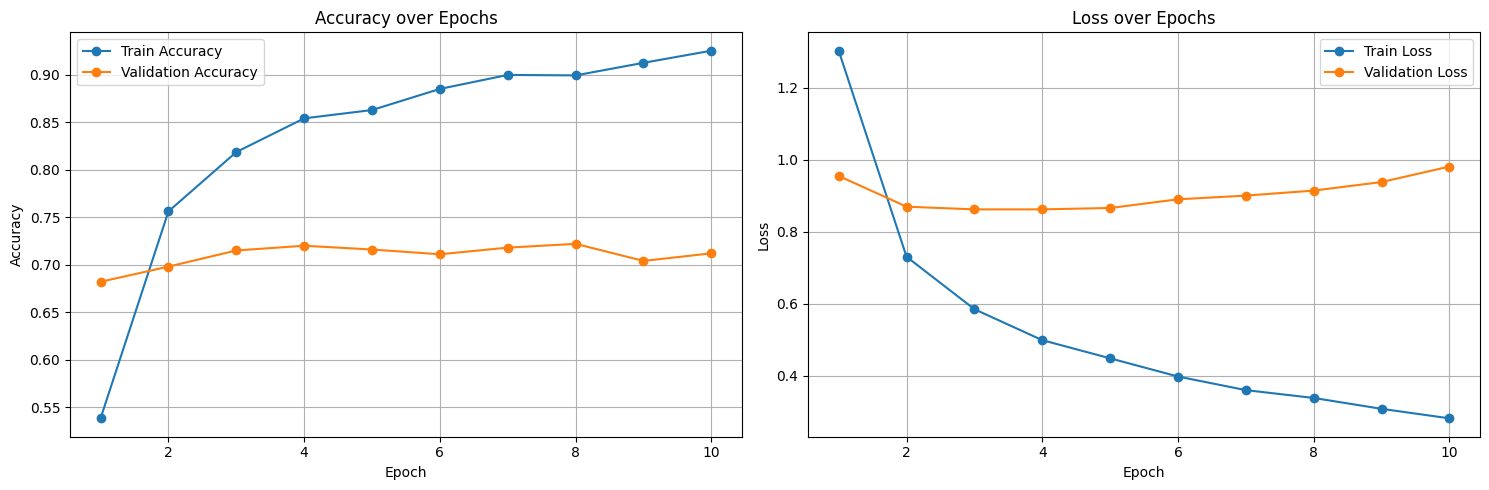

In [27]:
import matplotlib.pyplot as plt

# Create subplots: one for accuracy and one for loss
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot train and validation accuracy
axes[0].plot(range(1, len(train_accuracies) + 1), train_accuracies, marker='o', label="Train Accuracy")
axes[0].plot(range(1, len(val_accuracies) + 1), val_accuracies, marker='o', label="Validation Accuracy")
axes[0].set_title("Accuracy over Epochs")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Accuracy")
axes[0].grid(True)
axes[0].legend()

# Plot train and validation loss
axes[1].plot(range(1, len(train_losses) + 1), train_losses, marker='o', label="Train Loss")
axes[1].plot(range(1, len(val_losses) + 1), val_losses, marker='o', label="Validation Loss")
axes[1].set_title("Loss over Epochs")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Loss")
axes[1].grid(True)
axes[1].legend()

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

### ViT-Base Confusion Matrix Plot


In [28]:
# Generate predictions and true labels
y_true_classifier = []
y_pred_classifier = []
class_names = train_dataset.classes  # Automatically get class names from dataset

model.eval()  # Set model to evaluation mode
with torch.no_grad():
    for images, labels in val_loader_resized:  # Use the validation DataLoader
        images, labels = images.to(device), labels.to(device)
        logits = model(images)
        predictions = torch.argmax(logits, dim=1)
        y_true_classifier.extend(labels.cpu().numpy())
        y_pred_classifier.extend(predictions.cpu().numpy())

# Calculate confusion matrix
cm = confusion_matrix(y_true_classifier, y_pred_classifier)

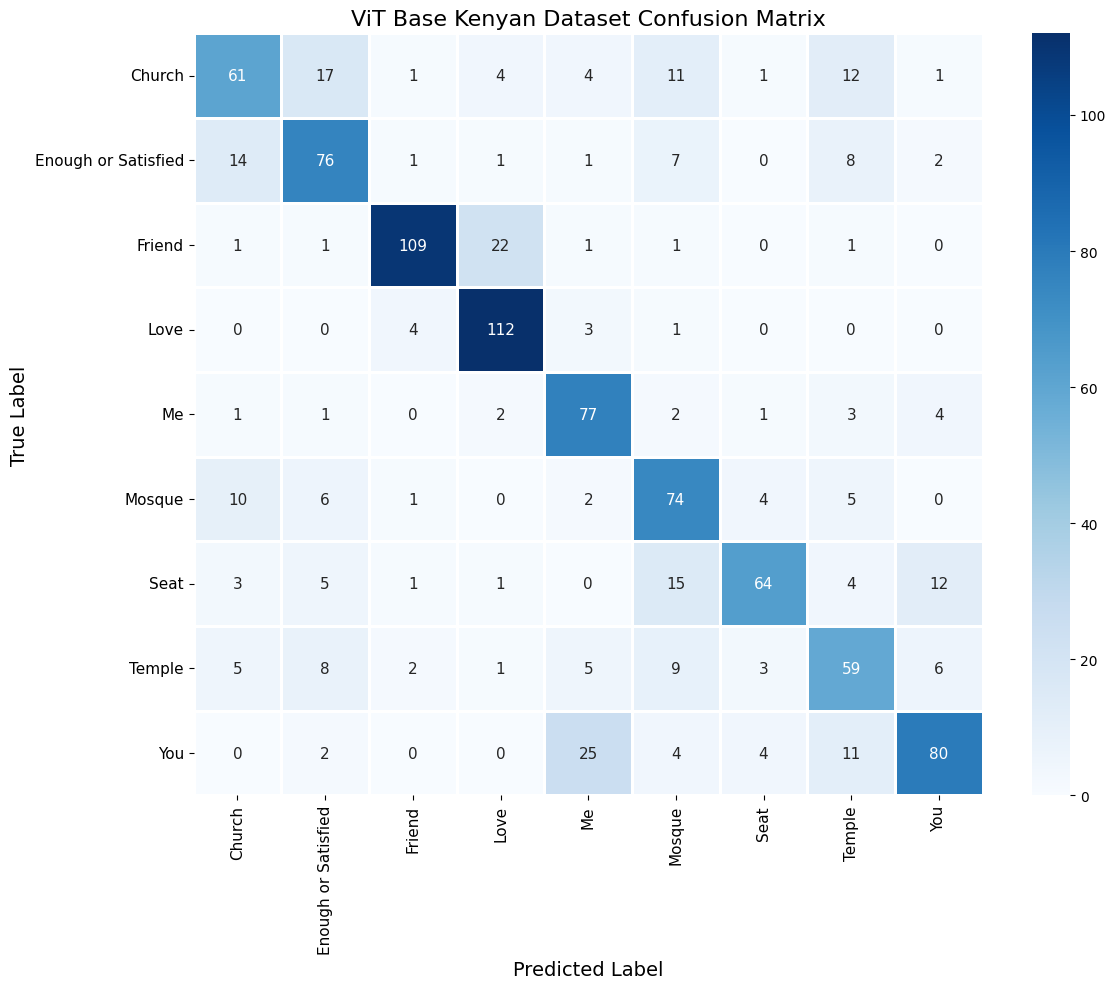

In [29]:
# Plot the confusion matrix with a larger figure size and bigger margins
plt.figure(figsize=(12, 10))  # Adjust the figsize to make the plot larger
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, cbar=True,
            annot_kws={"size": 11}, linewidths=1.8)  # Increase linewidth for better visibility of borders
plt.title("ViT Base Kenyan Dataset Confusion Matrix", fontsize=16)  # Increase font size of the title
plt.xlabel("Predicted Label", fontsize=14)  # Increase font size of the x-axis label
plt.ylabel("True Label", fontsize=14)  # Increase font size of the y-axis label
plt.xticks(fontsize=11)  # Set x-tick font size
plt.yticks(fontsize=11)

# Adjust the padding around the plot and labels
plt.subplots_adjust(left=0.2, right=0.8, top=0.85, bottom=0.15)  # Adjust the plot margins
plt.tight_layout()  # Ensure everything fits nicely within the plot area
plt.show()

### Calculate Test Accuracy


In [30]:
test_loss, test_accuracy = trainer.evaluate(test_loader_resized)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

Validating: 100%|██████████| 20/20 [00:37<00:00,  1.89s/batch]

Test Loss: 0.9003, Test Accuracy: 0.7240


## EfficientViT-M5 Tiny Fine-Tuning


In [12]:
from torch.optim.lr_scheduler import CosineAnnealingLR
import torch.nn as nn
from timm import create_model
import time
# Load the pre-trained ViT-Tiny model from timm
model = create_model(
    "efficientvit_m5.r224_in1k",  # Pre-trained ViT-Tiny on ImageNet-1k
    pretrained=True,         # Load pre-trained weights
    num_classes=num_classes  # Use dynamic number of classes
)



# Unfreeze the entire model (train all layers)
for param in model.parameters():
    param.requires_grad = True

# Define optimizer with adjusted learning rate and weight decay
optimizer = optim.AdamW(
    model.parameters(), lr=1e-4, weight_decay=5e-3
)

# Define CrossEntropy loss function
loss_fn = nn.CrossEntropyLoss()


# Define device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move model to device
model = model.to(device)

# Train the full ViT model
trainer = Trainer(model, optimizer, loss_fn, device, scheduler=None)

start_time = time.time()

train_losses, train_accuracies, val_losses, val_accuracies, learning_rates = trainer.train(
    train_loader_resized, val_loader_resized, epochs=13
)

# End timer after training
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Print learning rates for each epoch
print("Learning rates per epoch:", learning_rates)
print(f"Training completed in: {elapsed_time:.2f} seconds")

Epoch 1/13


Validating: 100%|██████████| 16/16 [00:07<00:00,  2.21batch/s]


Train Loss: 2.1599, Train Accuracy: 0.1930
Validation Loss: 2.0993, Validation Accuracy: 0.3170
Learning Rate: 0.000100
Epoch 2/13


Validating: 100%|██████████| 16/16 [00:07<00:00,  2.07batch/s]


Train Loss: 1.9486, Train Accuracy: 0.5059
Validation Loss: 1.8120, Validation Accuracy: 0.5580
Learning Rate: 0.000100
Epoch 3/13


Validating: 100%|██████████| 16/16 [00:08<00:00,  1.81batch/s]


Train Loss: 1.5304, Train Accuracy: 0.7129
Validation Loss: 1.3242, Validation Accuracy: 0.7100
Learning Rate: 0.000100
Epoch 4/13


Validating: 100%|██████████| 16/16 [00:07<00:00,  2.20batch/s]


Train Loss: 1.0366, Train Accuracy: 0.8150
Validation Loss: 0.9158, Validation Accuracy: 0.7840
Learning Rate: 0.000100
Epoch 5/13


Validating: 100%|██████████| 16/16 [00:07<00:00,  2.11batch/s]


Train Loss: 0.6652, Train Accuracy: 0.8770
Validation Loss: 0.6789, Validation Accuracy: 0.8350
Learning Rate: 0.000100
Epoch 6/13


Validating: 100%|██████████| 16/16 [00:08<00:00,  1.97batch/s]


Train Loss: 0.4313, Train Accuracy: 0.9187
Validation Loss: 0.5514, Validation Accuracy: 0.8590
Learning Rate: 0.000100
Epoch 7/13


Validating: 100%|██████████| 16/16 [00:07<00:00,  2.25batch/s]


Train Loss: 0.2982, Train Accuracy: 0.9457
Validation Loss: 0.4901, Validation Accuracy: 0.8640
Learning Rate: 0.000100
Epoch 8/13


Validating: 100%|██████████| 16/16 [00:10<00:00,  1.59batch/s]


Train Loss: 0.2042, Train Accuracy: 0.9687
Validation Loss: 0.4466, Validation Accuracy: 0.8680
Learning Rate: 0.000100
Epoch 9/13


Validating: 100%|██████████| 16/16 [00:10<00:00,  1.53batch/s]


Train Loss: 0.1425, Train Accuracy: 0.9827
Validation Loss: 0.4316, Validation Accuracy: 0.8740
Learning Rate: 0.000100
Epoch 10/13


Validating: 100%|██████████| 16/16 [00:07<00:00,  2.18batch/s]


Train Loss: 0.1062, Train Accuracy: 0.9867
Validation Loss: 0.4294, Validation Accuracy: 0.8660
Learning Rate: 0.000100
Epoch 11/13


Validating: 100%|██████████| 16/16 [00:08<00:00,  1.86batch/s]


Train Loss: 0.0843, Train Accuracy: 0.9897
Validation Loss: 0.4432, Validation Accuracy: 0.8690
Learning Rate: 0.000100
Epoch 12/13


Validating: 100%|██████████| 16/16 [00:08<00:00,  1.86batch/s]


Train Loss: 0.0666, Train Accuracy: 0.9937
Validation Loss: 0.4387, Validation Accuracy: 0.8630
Learning Rate: 0.000100
Epoch 13/13


Validating: 100%|██████████| 16/16 [00:08<00:00,  1.92batch/s]

Train Loss: 0.0487, Train Accuracy: 0.9960
Validation Loss: 0.4406, Validation Accuracy: 0.8750
Learning Rate: 0.000100
Learning rates per epoch: [0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001]
Training completed in: 683.50 seconds


### Validation - Training loss and accuracy plot


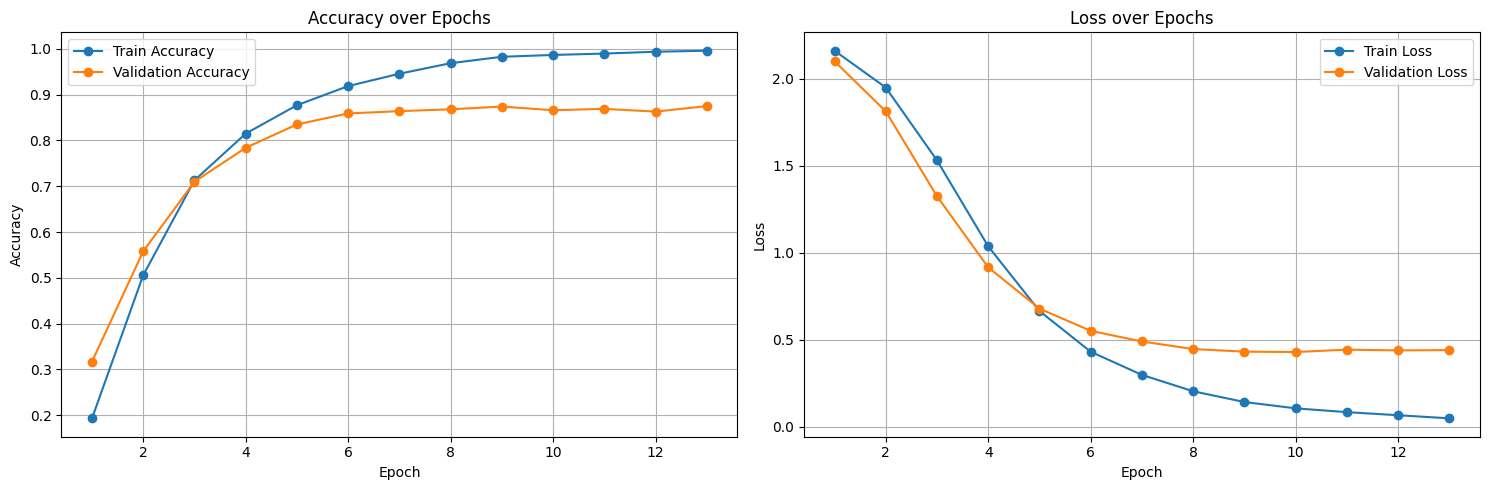

In [13]:
import matplotlib.pyplot as plt

# Create subplots: one for accuracy and one for loss
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot train and validation accuracy
axes[0].plot(range(1, len(train_accuracies) + 1), train_accuracies, marker='o', label="Train Accuracy")
axes[0].plot(range(1, len(val_accuracies) + 1), val_accuracies, marker='o', label="Validation Accuracy")
axes[0].set_title("Accuracy over Epochs")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Accuracy")
axes[0].grid(True)
axes[0].legend()

# Plot train and validation loss
axes[1].plot(range(1, len(train_losses) + 1), train_losses, marker='o', label="Train Loss")
axes[1].plot(range(1, len(val_losses) + 1), val_losses, marker='o', label="Validation Loss")
axes[1].set_title("Loss over Epochs")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Loss")
axes[1].grid(True)
axes[1].legend()

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

### EfficientViT-M5 Tiny Confusion Matrix Plot


In [14]:
# Generate predictions and true labels
y_true_classifier = []
y_pred_classifier = []
class_names = train_dataset.classes  # Automatically get class names from dataset

model.eval()  # Set model to evaluation mode
with torch.no_grad():
    for images, labels in val_loader_resized:  # Use the validation DataLoader
        images, labels = images.to(device), labels.to(device)
        logits = model(images)
        predictions = torch.argmax(logits, dim=1)
        y_true_classifier.extend(labels.cpu().numpy())
        y_pred_classifier.extend(predictions.cpu().numpy())

# Calculate confusion matrix
cm = confusion_matrix(y_true_classifier, y_pred_classifier)

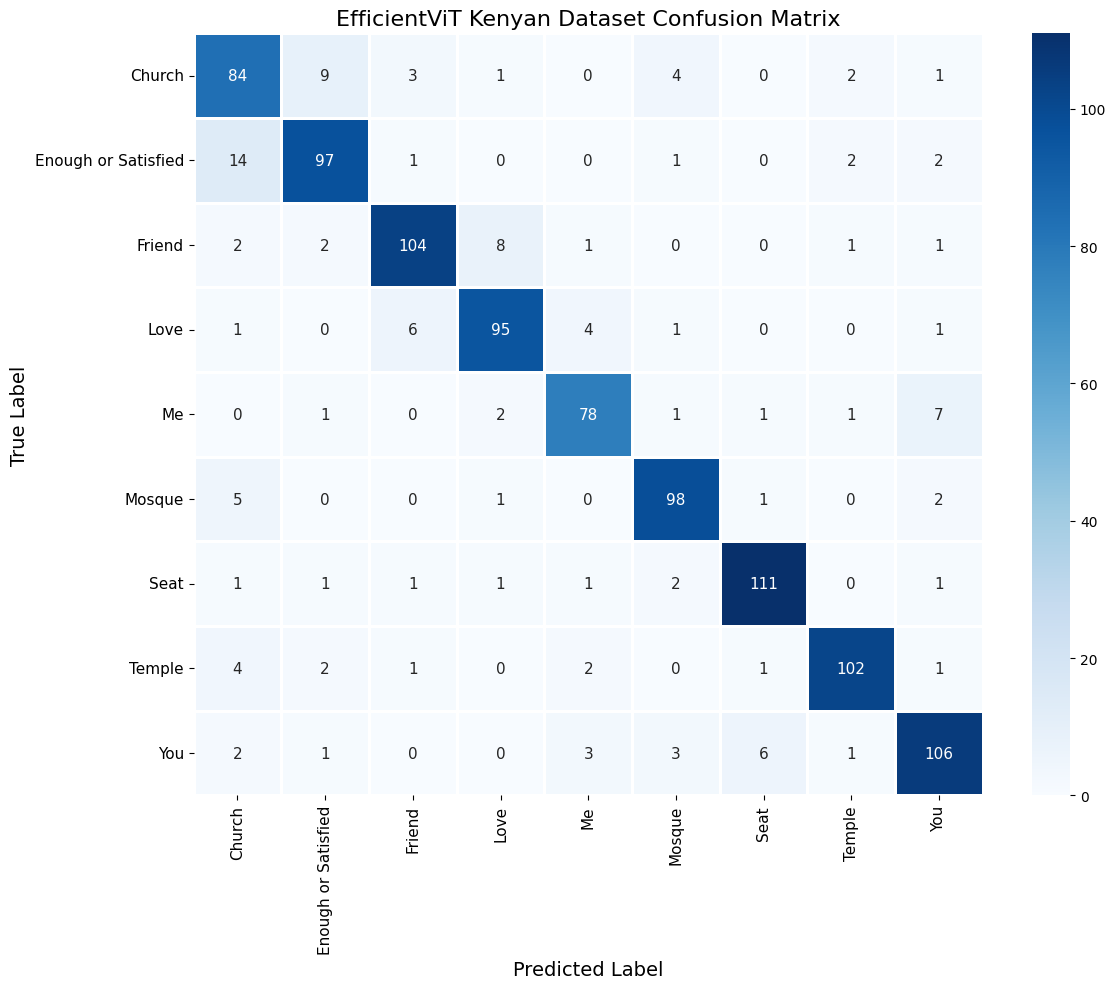

In [15]:
# Plot the confusion matrix with a larger figure size and bigger margins
plt.figure(figsize=(12, 10))  # Adjust the figsize to make the plot larger
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, cbar=True,
            annot_kws={"size": 11}, linewidths=1.8)  # Increase linewidth for better visibility of borders
plt.title("EfficientViT Kenyan Dataset Confusion Matrix", fontsize=16)  # Increase font size of the title
plt.xlabel("Predicted Label", fontsize=14)  # Increase font size of the x-axis label
plt.ylabel("True Label", fontsize=14)  # Increase font size of the y-axis label
plt.xticks(fontsize=11)  # Set x-tick font size
plt.yticks(fontsize=11)

# Adjust the padding around the plot and labels
plt.subplots_adjust(left=0.2, right=0.8, top=0.85, bottom=0.15)  # Adjust the plot margins
plt.tight_layout()  # Ensure everything fits nicely within the plot area
plt.show()

### Calculate Test Accuracy


In [16]:
test_loss, test_accuracy = trainer.evaluate(test_loader_resized)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

Validating: 100%|██████████| 20/20 [00:20<00:00,  1.04s/batch]

Test Loss: 0.4365, Test Accuracy: 0.8840


## DeIT-III Small Fine-tuning


In [9]:
from torch.optim.lr_scheduler import CosineAnnealingLR
import torch.nn as nn
from timm import create_model
import time
# Load the pre-trained ViT-Tiny model from timm
model = create_model(
    "deit3_small_patch16_224.fb_in22k_ft_in1k",  # Pre-trained ViT-Tiny on ImageNet-1k
    pretrained=True,         # Load pre-trained weights
    num_classes=num_classes  # Use dynamic number of classes
)


# Unfreeze the entire model (train all layers)
for param in model.parameters():
    param.requires_grad = True

# Define optimizer with adjusted learning rate and weight decay
optimizer = optim.AdamW(
    model.parameters(), lr=2e-4, weight_decay=1e-2
)

# Define CrossEntropy loss function
loss_fn = nn.CrossEntropyLoss()


# Define device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move model to device
model = model.to(device)

# Train the full ViT model
trainer = Trainer(model, optimizer, loss_fn, device, scheduler=None)

start_time = time.time()

train_losses, train_accuracies, val_losses, val_accuracies, learning_rates = trainer.train(
    train_loader_resized, val_loader_resized, epochs=2
)

# End timer after training
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Print learning rates for each epoch
print("Learning rates per epoch:", learning_rates)
print(f"Training completed in: {elapsed_time:.2f} seconds")

Epoch 1/2


Validating: 100%|██████████| 16/16 [00:10<00:00,  1.56batch/s]


Train Loss: 0.8641, Train Accuracy: 0.7069
Validation Loss: 0.4023, Validation Accuracy: 0.8820
Learning Rate: 0.000200
Epoch 2/2


Validating: 100%|██████████| 16/16 [00:10<00:00,  1.56batch/s]

Train Loss: 0.2251, Train Accuracy: 0.9322
Validation Loss: 0.2959, Validation Accuracy: 0.9150
Learning Rate: 0.000200
Learning rates per epoch: [0.0002, 0.0002]
Training completed in: 380.81 seconds


### Validation - Training loss and accuracy plot


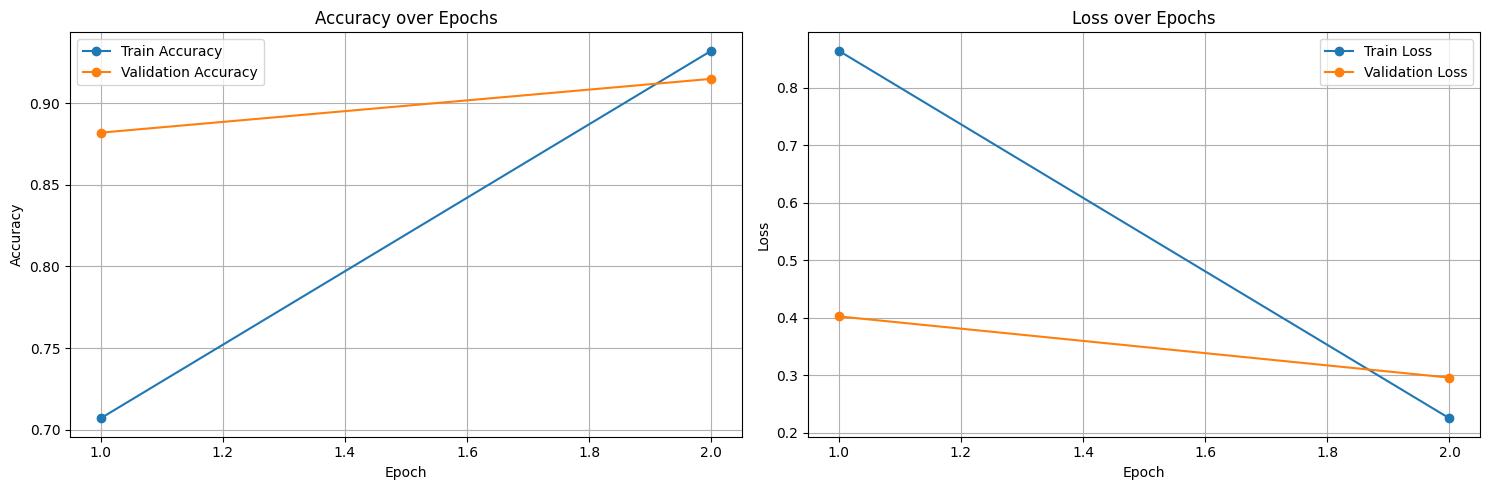

In [10]:
import matplotlib.pyplot as plt

# Create subplots: one for accuracy and one for loss
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot train and validation accuracy
axes[0].plot(range(1, len(train_accuracies) + 1), train_accuracies, marker='o', label="Train Accuracy")
axes[0].plot(range(1, len(val_accuracies) + 1), val_accuracies, marker='o', label="Validation Accuracy")
axes[0].set_title("Accuracy over Epochs")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Accuracy")
axes[0].grid(True)
axes[0].legend()

# Plot train and validation loss
axes[1].plot(range(1, len(train_losses) + 1), train_losses, marker='o', label="Train Loss")
axes[1].plot(range(1, len(val_losses) + 1), val_losses, marker='o', label="Validation Loss")
axes[1].set_title("Loss over Epochs")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Loss")
axes[1].grid(True)
axes[1].legend()

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

### DeIT-III Small Confusion Matrix Plot

In [11]:
# Generate predictions and true labels
y_true_classifier = []
y_pred_classifier = []
class_names = train_dataset.classes  # Automatically get class names from dataset

model.eval()  # Set model to evaluation mode
with torch.no_grad():
    for images, labels in val_loader_resized:  # Use the validation DataLoader
        images, labels = images.to(device), labels.to(device)
        logits = model(images)
        predictions = torch.argmax(logits, dim=1)
        y_true_classifier.extend(labels.cpu().numpy())
        y_pred_classifier.extend(predictions.cpu().numpy())

# Calculate confusion matrix
cm = confusion_matrix(y_true_classifier, y_pred_classifier)

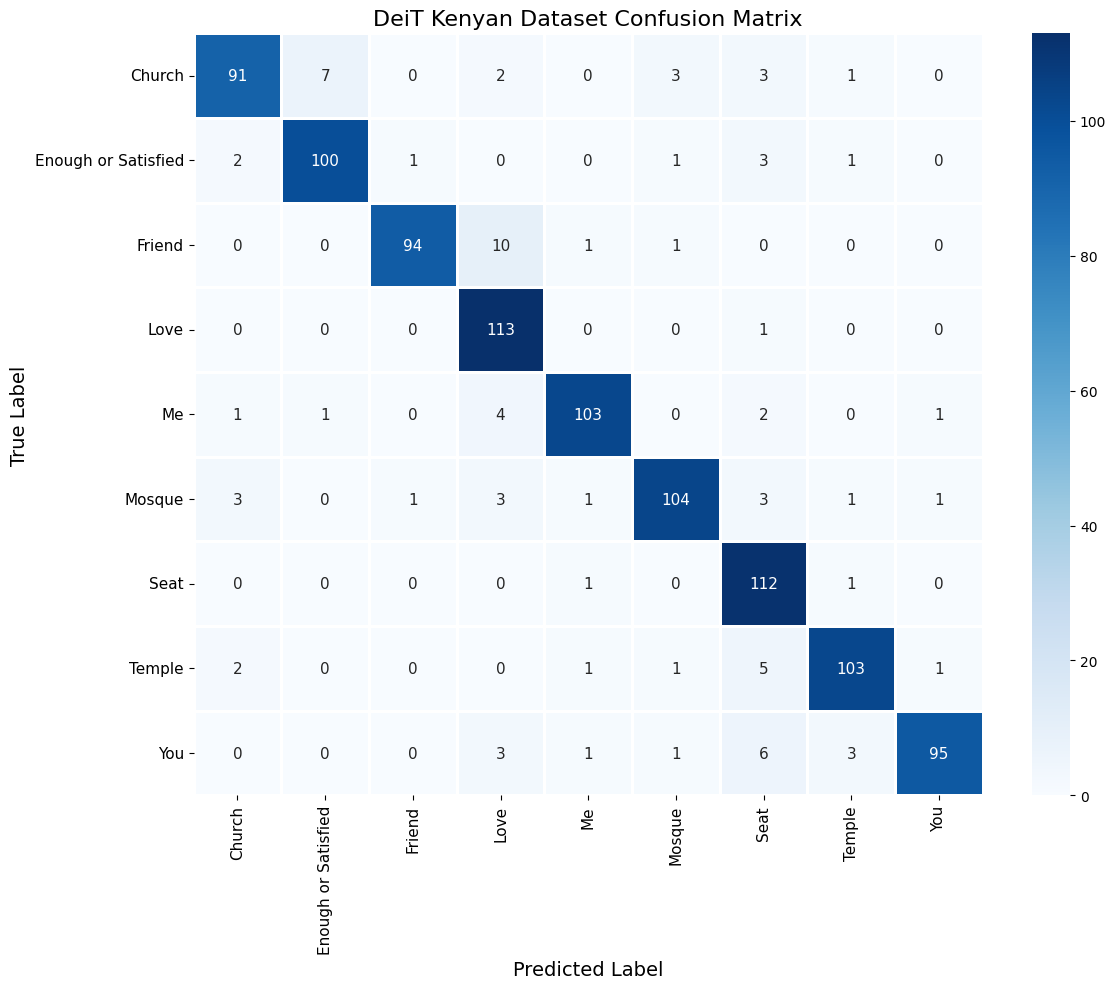

In [12]:
# Plot the confusion matrix with a larger figure size and bigger margins
plt.figure(figsize=(12, 10))  # Adjust the figsize to make the plot larger
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, cbar=True,
            annot_kws={"size": 11}, linewidths=1.8)  # Increase linewidth for better visibility of borders
plt.title("DeiT Kenyan Dataset Confusion Matrix", fontsize=16)  # Increase font size of the title
plt.xlabel("Predicted Label", fontsize=14)  # Increase font size of the x-axis label
plt.ylabel("True Label", fontsize=14)  # Increase font size of the y-axis label
plt.xticks(fontsize=11)  # Set x-tick font size
plt.yticks(fontsize=11)

# Adjust the padding around the plot and labels
plt.subplots_adjust(left=0.2, right=0.8, top=0.85, bottom=0.15)  # Adjust the plot margins
plt.tight_layout()  # Ensure everything fits nicely within the plot area
plt.show()

### Calculate Test Accuracy


In [13]:
test_loss, test_accuracy = trainer.evaluate(test_loader_resized)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

Validating: 100%|██████████| 20/20 [00:21<00:00,  1.07s/batch]

Test Loss: 0.3189, Test Accuracy: 0.9040
